# FBI Gun Data Analysis

## Table of Content:
<ul>
<li><a href = '#introduction'>Introduction</a></li>
<li><a href = '#data_wrangling'>Data Wrangling</a></li>
<li><a href = '#exploratory_data_analysis'>Exploratory Data Analysis</a></li>
<li><a href = '#conclusion'>Conclusion</a></li>
<ul>
    

<a id='introduction'></a>
## Introduction



<a id = 'data_wrangling'></a>
## Data Wrangling

In [31]:
#import all needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
%matplotlib inline


In [32]:
#show orginal data of 'us_census data.csv':
df1 = pd.read_csv('us_census data.csv')
df1.head()

,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,"Population estimates, July 1, 2016, (V2016)",NaN,"4,863,300","741,894","6,931,071","2,988,248","39,250,017","5,540,545","3,576,452","952,065",...,865454,6651194,"27,862,596","3,051,217","624,594","8,411,808","7,288,000","1,831,102","5,778,708","585,501"
1,"Population estimates base, April 1, 2010, (V2...",NaN,"4,780,131","710,249","6,392,301","2,916,025","37,254,522","5,029,324","3,574,114","897,936",...,814195,6346298,"25,146,100","2,763,888","625,741","8,001,041","6,724,545","1,853,011","5,687,289","563,767"
2,"Population, percent change - April 1, 2010 (es...",NaN,1.70%,4.50%,8.40%,2.50%,5.40%,10.20%,0.10%,6.00%,...,0.063,0.048,10.80%,10.40%,-0.20%,5.10%,8.40%,-1.20%,1.60%,3.90%
3,"Population, Census, April 1, 2010",NaN,"4,779,736","710,231","6,392,017","2,915,918","37,253,956","5,029,196","3,574,097","897,934",...,814180,6346105,"25,145,561","2,763,885","625,741","8,001,024","6,724,540","1,852,994","5,686,986","563,626"
4,"Persons under 5 years, percent, July 1, 2016, ...",NaN,6.00%,7.30%,6.30%,6.40%,6.30%,6.10%,5.20%,5.80%,...,0.071,0.061,7.20%,8.30%,4.90%,6.10%,6.20%,5.50%,5.80%,6.50%


In [33]:
df1 = df1.drop(columns = ['Fact Note']) #Drop the Fact Note column since it contains no useful information for analysis
df1 = df1[:64] #drop all the footnote and keep only the useful data with numbers
df1 = df1.replace({'Z':'0','D':'0','FN':'0'}) #Replace all Z,D and FN with 0 based on the footnote definition

states = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','Florida',\
       'Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland',\
       'Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey',\
       'New Mexico','New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island',\
       'South Carolina','South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']

#remove all ',' '%' and '$' and convert the data type from string to float
for state in states:
    df1[state] = df1[state].astype(str).replace({'\$': '', ',': '','%':''}, regex=True).astype('float64')

#show the new us_census_data after the wranglin
df1.head(5) 




,Fact,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,"Population estimates, July 1, 2016, (V2016)",4863300.0,741894.0,6931071.0,2988248.0,39250017.0,5540545.0,3576452.0,952065.0,20612439.0,...,865454.000,6651194.000,27862596.0,3051217.0,624594.0,8411808.0,7288000.0,1831102.0,5778708.0,585501.0
1,"Population estimates base, April 1, 2010, (V2...",4780131.0,710249.0,6392301.0,2916025.0,37254522.0,5029324.0,3574114.0,897936.0,18804592.0,...,814195.000,6346298.000,25146100.0,2763888.0,625741.0,8001041.0,6724545.0,1853011.0,5687289.0,563767.0
2,"Population, percent change - April 1, 2010 (es...",1.7,4.5,8.4,2.5,5.4,10.2,0.1,6.0,9.6,...,0.063,0.048,10.8,10.4,-0.2,5.1,8.4,-1.2,1.6,3.9
3,"Population, Census, April 1, 2010",4779736.0,710231.0,6392017.0,2915918.0,37253956.0,5029196.0,3574097.0,897934.0,18801310.0,...,814180.000,6346105.000,25145561.0,2763885.0,625741.0,8001024.0,6724540.0,1852994.0,5686986.0,563626.0
4,"Persons under 5 years, percent, July 1, 2016, ...",6.0,7.3,6.3,6.4,6.3,6.1,5.2,5.8,5.5,...,0.071,0.061,7.2,8.3,4.9,6.1,6.2,5.5,5.8,6.5


In [34]:
df1.info() #show the information of the of modified dataframe1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 51 columns):
Fact              64 non-null object
Alabama           64 non-null float64
Alaska            64 non-null float64
Arizona           64 non-null float64
Arkansas          64 non-null float64
California        64 non-null float64
Colorado          64 non-null float64
Connecticut       64 non-null float64
Delaware          64 non-null float64
Florida           64 non-null float64
Georgia           64 non-null float64
Hawaii            64 non-null float64
Idaho             64 non-null float64
Illinois          64 non-null float64
Indiana           64 non-null float64
Iowa              64 non-null float64
Kansas            64 non-null float64
Kentucky          64 non-null float64
Louisiana         64 non-null float64
Maine             64 non-null float64
Maryland          64 non-null float64
Massachusetts     64 non-null float64
Michigan          64 non-null float64
Minnesota         64 non

In [35]:
df2 = pd.read_csv('gun_data.csv') #read the original gun_data.csv 
df2.head()

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017-09,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,15.0,...,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019
1,2017-09,Alaska,209.0,2.0,2320.0,2930.0,219.0,160,0.0,5.0,...,0.0,0.0,0.0,17.0,24.0,1.0,0.0,0.0,0.0,6303
2,2017-09,Arizona,5069.0,382.0,11063.0,7946.0,920.0,631,0.0,13.0,...,0.0,0.0,0.0,38.0,12.0,2.0,0.0,0.0,0.0,28394
3,2017-09,Arkansas,2935.0,632.0,4347.0,6063.0,165.0,366,51.0,12.0,...,0.0,0.0,0.0,13.0,23.0,0.0,0.0,2.0,1.0,17747
4,2017-09,California,57839.0,0.0,37165.0,24581.0,2984.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123506


In [36]:
df2.info() #show info of the orginal file

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12485 entries, 0 to 12484
Data columns (total 27 columns):
month                        12485 non-null object
state                        12485 non-null object
permit                       12461 non-null float64
permit_recheck               1100 non-null float64
handgun                      12465 non-null float64
long_gun                     12466 non-null float64
other                        5500 non-null float64
multiple                     12485 non-null int64
admin                        12462 non-null float64
prepawn_handgun              10542 non-null float64
prepawn_long_gun             10540 non-null float64
prepawn_other                5115 non-null float64
redemption_handgun           10545 non-null float64
redemption_long_gun          10544 non-null float64
redemption_other             5115 non-null float64
returned_handgun             2200 non-null float64
returned_long_gun            2145 non-null float64
returned_other   

In [37]:
df2 = df2.fillna(0) #fill NaN in the dataframe with 0

#convert all numbers to float data type
df2[['permit','permit_recheck','handgun','long_gun','other','multiple','admin','prepawn_handgun','prepawn_long_gun',\
     'prepawn_other','redemption_handgun','redemption_long_gun','redemption_other','returned_handgun',\
     'returned_long_gun','returned_other','rentals_handgun','rentals_long_gun','private_sale_handgun',\
     'private_sale_long_gun','private_sale_other','return_to_seller_handgun','return_to_seller_long_gun',\
     'return_to_seller_other','totals']].astype(float, inplace = True)

# convert the month column to datetime format
df2['month'] = pd.to_datetime(df2['month'])

# show first 5 columns of modified gun_data.csv
df2.head() 


,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017-09-01,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,15.0,...,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019
1,2017-09-01,Alaska,209.0,2.0,2320.0,2930.0,219.0,160,0.0,5.0,...,0.0,0.0,0.0,17.0,24.0,1.0,0.0,0.0,0.0,6303
2,2017-09-01,Arizona,5069.0,382.0,11063.0,7946.0,920.0,631,0.0,13.0,...,0.0,0.0,0.0,38.0,12.0,2.0,0.0,0.0,0.0,28394
3,2017-09-01,Arkansas,2935.0,632.0,4347.0,6063.0,165.0,366,51.0,12.0,...,0.0,0.0,0.0,13.0,23.0,0.0,0.0,2.0,1.0,17747
4,2017-09-01,California,57839.0,0.0,37165.0,24581.0,2984.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123506


In [38]:
df2.info() #showing the information of the modified datafame2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12485 entries, 0 to 12484
Data columns (total 27 columns):
month                        12485 non-null datetime64[ns]
state                        12485 non-null object
permit                       12485 non-null float64
permit_recheck               12485 non-null float64
handgun                      12485 non-null float64
long_gun                     12485 non-null float64
other                        12485 non-null float64
multiple                     12485 non-null int64
admin                        12485 non-null float64
prepawn_handgun              12485 non-null float64
prepawn_long_gun             12485 non-null float64
prepawn_other                12485 non-null float64
redemption_handgun           12485 non-null float64
redemption_long_gun          12485 non-null float64
redemption_other             12485 non-null float64
returned_handgun             12485 non-null float64
returned_long_gun            12485 non-null float64
ret

<a id = 'exploratory_data_analysis'></a>
## Exploratory Data Analysis

### 1. Gun per capita of different states

#### 1.1 Population for different states (Year 2010)

[Text(0,0.5,'Population'), Text(0.5,0,'States')]

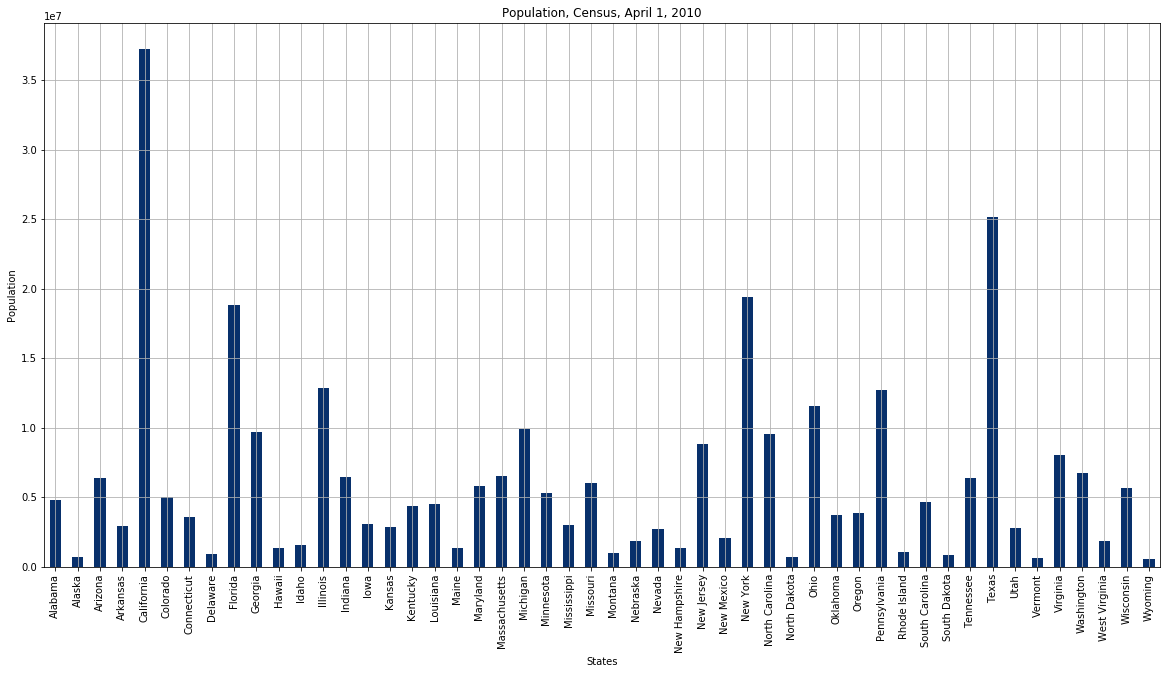

In [39]:
df1_popu_y2010 = df1.iloc[3,1:] # select the info of population census at year 2010 for different states

#plot the population of different states
df1_popu_y2010.plot.bar(figsize = (20,10), colormap = 'Blues_r',grid = True, \
                        title = 'Population, Census, April 1, 2010').set(xlabel = 'States', ylabel = 'Population')

#### 1.2  Total permits of different states (Year 2010)

[Text(0,0.5,'Total Permits')]

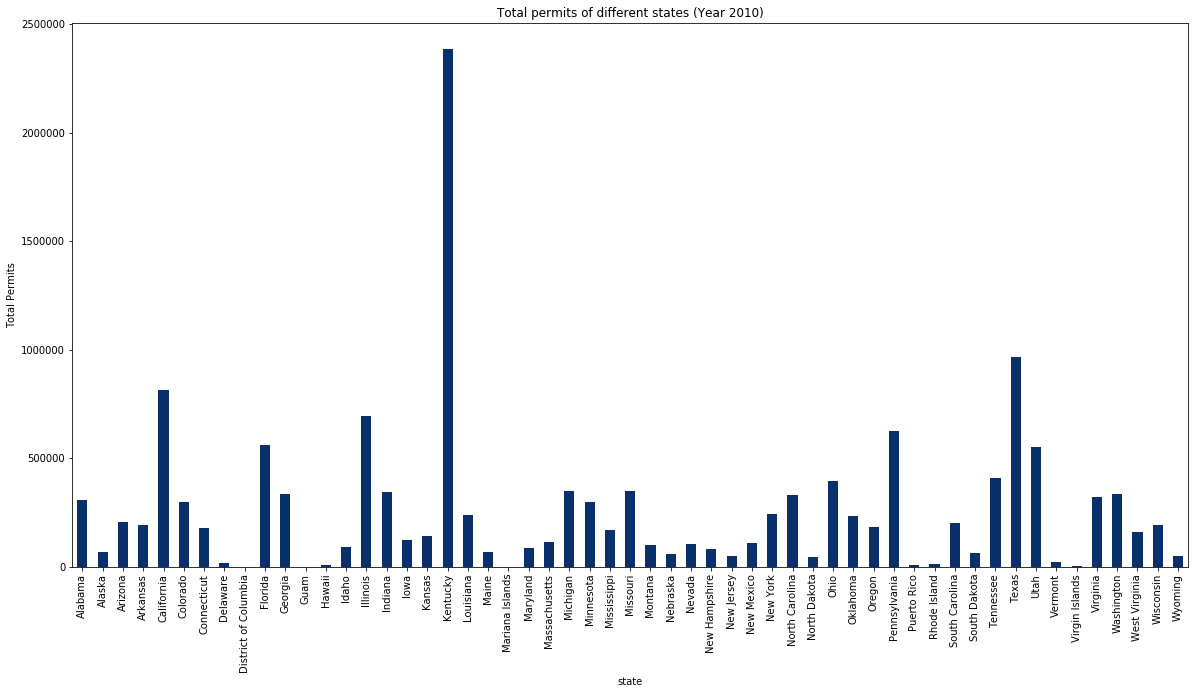

In [40]:
df2['year'] = df2['month'].dt.year #create a new column stores the information of year for each row
df2_gun_y2010 = df2.loc[df2['year'] == 2010] #select rows with year 2010
df2_gun_y2010 = df2_gun_y2010.groupby(df2_gun_y2010['state'])['totals'].sum() #calculate the sum of totals for all months and \
                                                                  #and group by the results based on states

#plot the final result
df2_gun_y2010.plot.bar(figsize = (20,10),title = 'Total permits of different states (Year 2010)',\
                       colormap = 'Blues_r').set(ylabel = 'Total Permits') 


#### 1.3 Gun per capita of different states

[Text(0,0.5,'Number of Gun permits per Person '), Text(0.5,0,'States')]

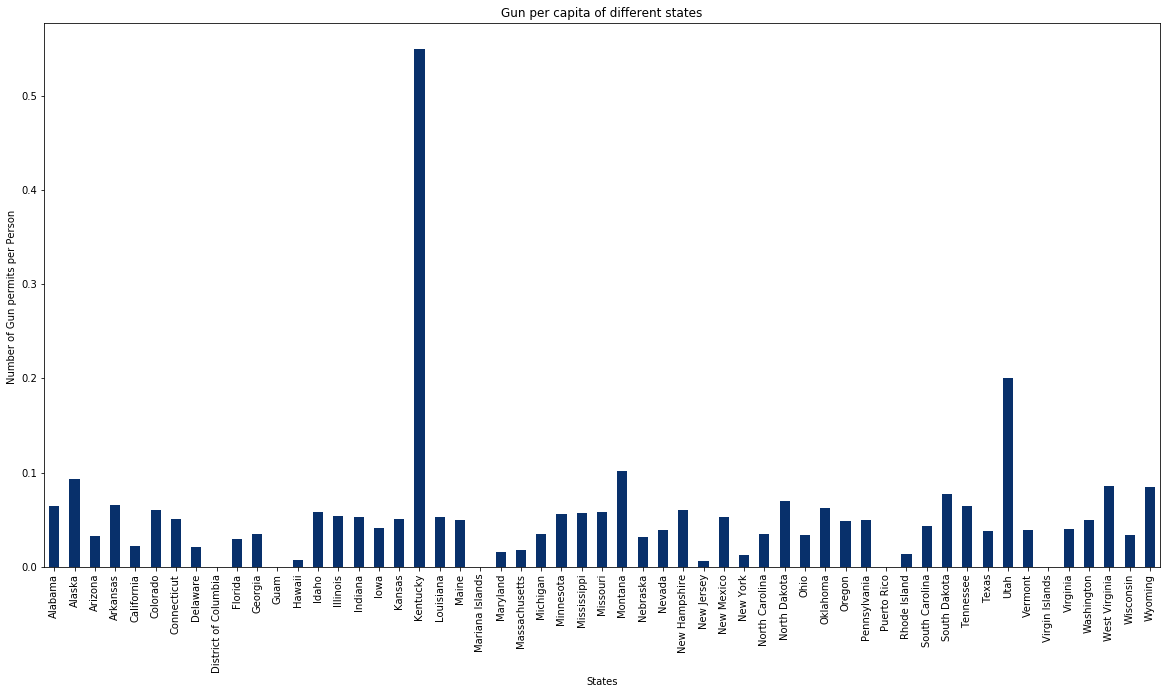

In [41]:
df_gun_percapita_y2010 = (df2_gun_y2010/df1_popu_y2010).fillna(0) #calculate the per capita gun permit at different
                                                                  #state
# Plot the final result
df_gun_percapita_y2010.plot.bar(figsize = (20,10), title = 'Gun per capita of different states', colormap = 'Blues_r')\
.set(xlabel = 'States', ylabel = 'Number of Gun permits per Person ')


### 2. Change of total permits for United States and different states from 1999 - 2016

#### 2.1 Change of total permits for United States from 1999 - 2016

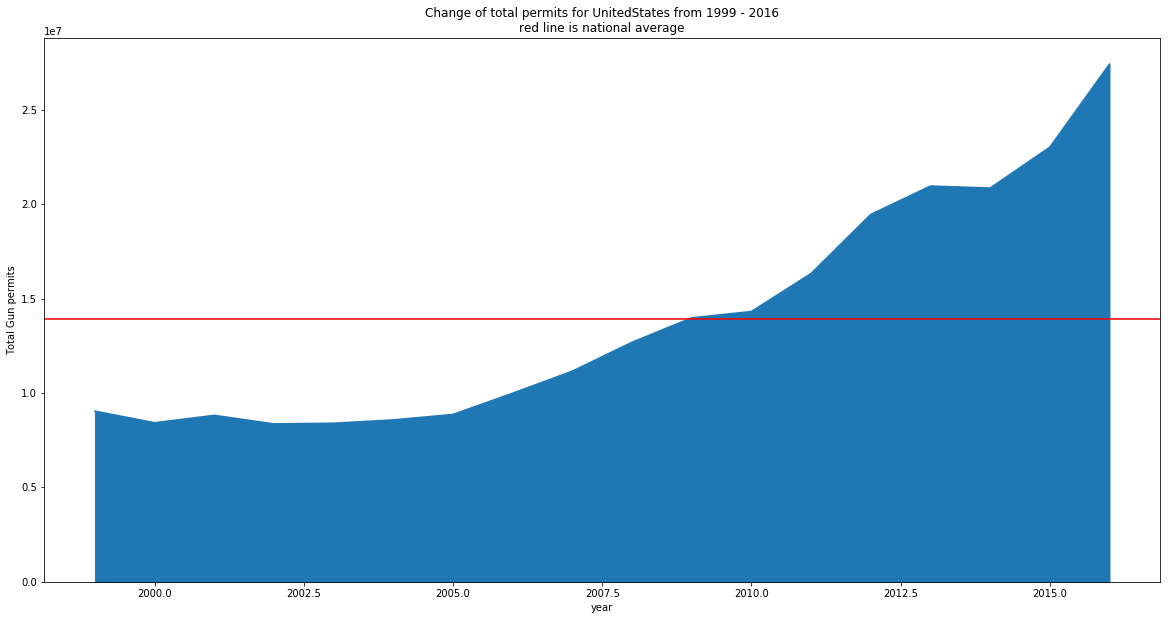

In [42]:
df2_gun_1998_to_2017_allstates = df2.groupby(['year']).sum() # Calculate the all-state total for different years
df2_gun_1998_to_2017_allstates.head() # show first few rows of the data
df2_gun_1999_to_2016_allstates = df2_gun_1998_to_2017_allstates.iloc[1:-1] # pick only the data from 1999 to 2016\
                                                                           # since they contain all months

national_avg_1999_to_2016 = df2_gun_1999_to_2016_allstates['totals'].mean() # this will calculate the national average

#plot the final result
df2_gun_1999_to_2016_allstates['totals'].plot.area(figsize = (20,10),title = 'Change of total permits for United\
States from 1999 - 2016\nred line is national average').set(ylabel = 'Total Gun permits')
#plot the national average line
plt.axhline(y=national_avg_1999_to_2016, xmin=0, xmax=1, hold=None, color = 'red') 

#### 2.2 Change of total permits for different states from 1999 - 2016

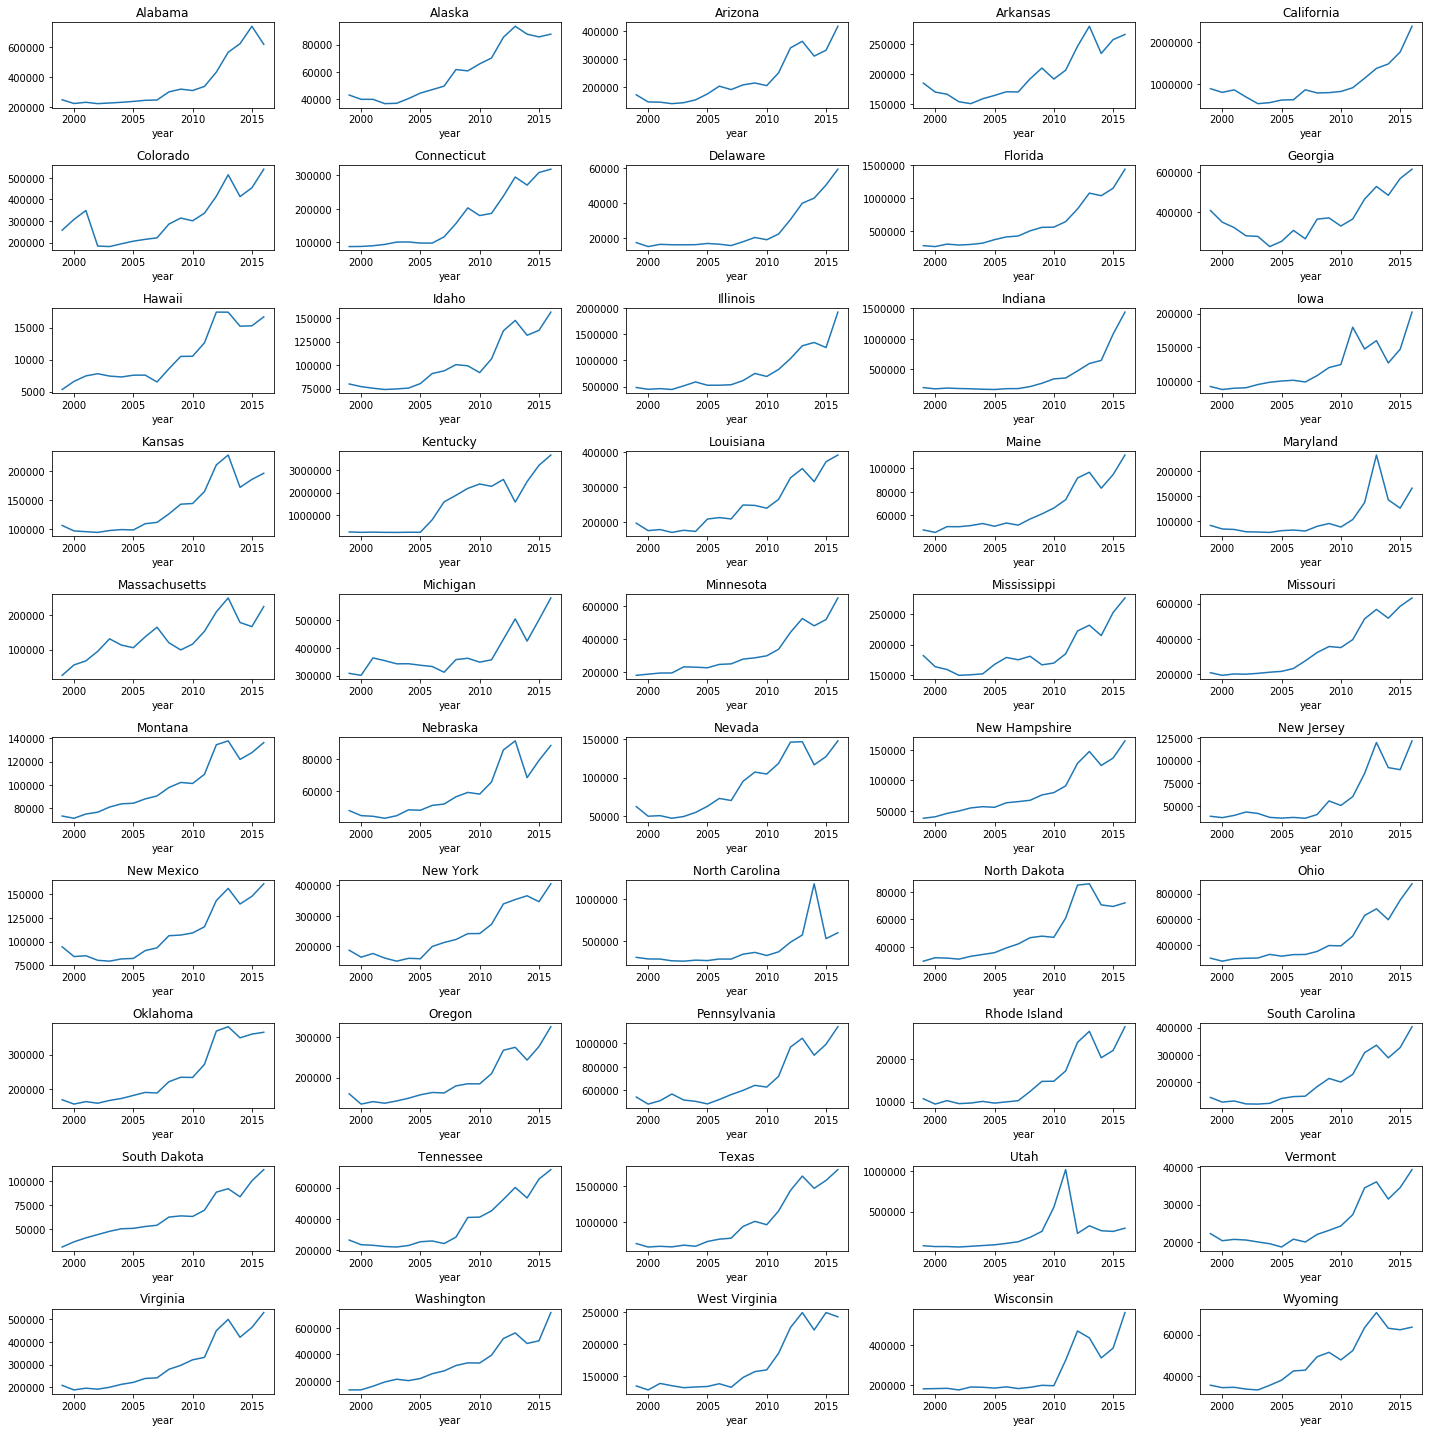

In [67]:
df2_gun_1998_to_2017_single_states = df2.groupby(['state']) #group the df2 data by states


fig, axes = plt.subplots(nrows=10, ncols=5) #create a figure with 50 empty subplot spots
i = 0
k = 0
for state in states:
    if k <= 4:
        # Group the modified df2 with selected state by 'year' calculate the yearly sum. Then, drop the data for 1988\
        #and 2017 because they don't include the whole year
        df2_state_1999_to_2016 = df2_gun_1998_to_2017_single_states.get_group(state).groupby(['year']).sum()[1:-1]
        #plot a subplot of a selected state 
        df2_state_1999_to_2016['totals'].plot(ax=axes[i,k],figsize = (20,20),title = state)
        #move to next column positon on the same row
        k = k + 1 
    elif k > 4:
        # move the column to position 0
        k = 0
        # move the to next row
        i = i + 1
        df2_state_1999_to_2016 = df2_gun_1998_to_2017_single_states.get_group(state).groupby(['year']).sum()[1:-1]
        df2_state_1999_to_2016['totals'].plot(ax=axes[i,k],figsize = (20,20),title = state)
        k = k + 1
        
plt.tight_layout()




<a id = 'conclusion'></a>
## Coclusion